In [2]:
#| code-fold: true
!pip install -Uqq fastbook nbdev torch
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [the previous
post](https://mlops.systems/fastai/computervision/pytorch/2022/05/13/sgd-whole-game.html)
I used the seven-step process to fit to an unknown function. The process as a
whole is fairly simple to get your head around, but there are a good few details
to keep track of along the way. This will continue to be the case as we get into
this walkthrough of how to do the same for the Fashion MNIST pullover vs dress data.

# Getting our data into the right format

The first thing we need to handle is making sure our data is in the right
format, shape and so on. We begin by downloading our data and splitting the data
into training and test sets.

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

training_dresses = [item[0][0] for item in training_data if item[1] == 3]
training_pullovers = [item[0][0] for item in training_data if item[1] == 2]
test_dresses = [item[0][0] for item in test_data if item[1] == 3]
test_pullovers = [item[0][0] for item in test_data if item[1] == 2]

training_dresses_tensor = torch.stack(training_dresses)
training_pullovers_tensor = torch.stack(training_pullovers)
test_dresses_tensor = torch.stack(test_dresses)
test_pullovers_tensor = torch.stack(test_pullovers)

training_dresses_tensor.shape, test_dresses_tensor.shape

(torch.Size([6000, 28, 28]), torch.Size([1000, 28, 28]))

In [5]:
train_x = torch.cat([training_dresses_tensor, training_pullovers_tensor]).view(-1, 28*28)
train_y = torch.cat([torch.ones(len(training_dresses)), torch.zeros(len(training_pullovers))]).unsqueeze(1)

valid_x = torch.cat([test_dresses_tensor, test_pullovers_tensor]).view(-1, 28*28)
valid_y = torch.cat([torch.ones(len(test_dresses)), torch.zeros(len(test_pullovers))]).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12000, 784]), torch.Size([12000, 1]))

We transform our images tensors from matrices into vectors with all the values
one after another. We create a `train_y` vector with our labels which we can use
to check how well we did with our predictions.

We create datasets out of our tensors. This means that we can feed our data into
our training functions in the way that is most convenient (i.e. an image is
paired with the correct label).

In [6]:
train_dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))

# Initialising our weights and bias

As in the previous times where we've done this, we initialise our parameters or
weights with random values. This means that for every pixel represented in the
images, we'll start off with purely random values. We initialise our bias to a
random number as well.

In [7]:
def initialise_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()

weights = initialise_params((28*28, 1))
bias = initialise_params(1)

In [9]:
# calculating a prediction for our first image
(train_x[0]*weights.T).sum() + bias

tensor([2.8681], grad_fn=<AddBackward0>)

# Matrix multiplication to calculate our predictions

We'll need to make many calculations like the one we just made, and luckily the
technique of matrix multiplication helps us with exactly the scenario we have:
we want to multiply the values of our image (laid out in a single vector) with
the weights and to add the bias.

In Python, matrix multiplication is carried out with a simple `@` operator, so
we can bring all of this together as a function:

In [11]:
def linear1(x_batch):
    return x_batch@weights + bias

preds = linear1(train_x)
preds

tensor([[  2.8681],
        [ -7.6810],
        [-17.5719],
        ...,
        [ -3.8665],
        [  2.0646],
        [ -2.5148]], grad_fn=<AddBackward0>)

We can check our accuracy for these predictions:

In [12]:
corrects = (preds > 0.0).float() == train_y
corrects.float().mean().item()

0.35324999690055847

Our accuracy is pretty poor! A lot worse than even 50/50 luck which is what
you'd expect to get on average from a random set of initial weights. Apparently
we had a bad draw of luck this time round!

# A loss function to evaluate model performance

We now need a loss function which will tell us how well we are doing in our
predictions, and that can be used as part of the gradient calculations to let us
know (as we iterate) how to update our weights.

The problem, especially in the data set we're working with, is that we have a
binary probability: either it's a dress or a pullover. Zero or one. Unlike in a
regression problem, or something similar, we don't have any smooth selection of
contiguous values that get predicted. We have zero or one.

At this point we learn about the sigmoid function which is a way to reframe this
problem in a way that we can use to our advantage. The sigmoid function when
plotted looks like this:

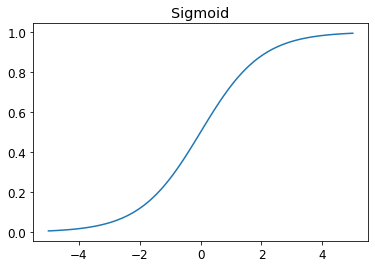

In [13]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

plot_function(torch.sigmoid, title="Sigmoid", min=-5, max=5)

This function, as you can see, takes any input value and squashes it down such
that the output value is between 0 and 1. It also has a smooth curve, all headed
in the same direction, between those values. This is ideal for our situation.
The first thing we must do as part of our loss function, therefore, is to apply
the sigmoid function to the inputs.

In [14]:
def fashion_mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1 - predictions, predictions).mean()

This `torch.where(...)` function is a handy way of iterating through all our
data, checking whether our target is 1 or not, then outputting the distance from
the correct prediction and calculating the mean of these predictions across the
entire dataset.

# DataLoaders and Datasets

We've already created datasets for our training and validation data. The process
of iterating through our data, however, requires some thought as to how we'll do
it. Our options:

- we could iterate through the entire dataset, making the relevant loss and
  gradient calculations and adjusting the weights but this might make the
  process quite long, even though we'd benefit from the increased accuracy this
  would bring since we'd be seeing the entire dataset each iteration.
- we could do our calculations after just seeing a single image, but then our
  model would be over-influenced and perturbed by the fluctuations from image to
  image. This also wouldn't be what we want.

In practice, we'll need to choose something in between. This is where
mini-batches or just 'batches' come in. These will be need to be large enough
(and randomly populated!) that our model can meaningfully learn from them, but
not so large that our process takes too long.

Luckily, we have the abstraction of the `DataLoader` which will create all our
randomly assigned batches for us.

In [15]:
train_dl = DataLoader(train_dset, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=True)

# Training our model

Now we can bring the whole process together and train our model:

In [16]:
weights = initialise_params((28*28, 1))
bias = initialise_params(1)

def calculate_gradient(x_batch, y_batch, model):
    preds = model(x_batch)
    loss = fashion_mnist_loss(preds, y_batch)
    loss.backward()

def train_epoch(model, learning_rate, params):
    # iterate over the training data, batch by batch
    for x_batch, y_batch in train_dl:
        # calculate the gradients
        calculate_gradient(x_batch, y_batch, model)
        
        for param in params:
            param.data -= param.grad * learning_rate
            # set the gradients to zero
            param.grad.zero_()

def batch_accuracy(x_batch, y_batch):
    preds = x_batch.sigmoid()
    correct = (preds > 0.5) == y_batch
    return correct.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(x_batch), y_batch) for x_batch, y_batch in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1)

0.2173

We start there, but now we can train and watch our accuracy improving:

In [17]:
learning_rate = 1.
params = weights, bias

for _ in range(30):
    train_epoch(linear1, learning_rate, params)
    print(validate_epoch(linear1), end=" ")

0.5001 0.5016 0.7994 0.9357 0.9481 0.9523 0.9537 0.9555 0.9572 0.9582 0.9578 0.9604 0.9608 0.9609 0.962 0.9611 0.9622 0.9626 0.9631 0.9625 0.963 0.963 0.9633 0.9638 0.964 0.9631 0.9638 0.9638 0.9643 0.9645 

We had 91% accuracy on our validation dataset [last time we tried
this](https://mlops.systems/fastai/computervision/pytorch/2022/05/11/fashion-mnist-pixel-similarity.html#Using-broadcasting-to-check-our-predictions-on-our-validation-data)
with pixel similarity.

After 30 epochs of training with our new process we've achieved 96%, but we
could still do better! We'll tackle that in the next post.


# Optimising with an Optimiser

Everything that we've been doing so far is so common that there is pre-built
functionality to handle all of the pieces.

- our `linear1` function (which calculated predictions based on our weights and
  biases) can be replaced with PyTorch's `nn.Linear` module. Actually,
  `nn.Linear` does the same thing as our `initialise_params` and our `linear1`
  function combined.

In [19]:
# initialises our weights and bias, and is our model / function
linear_model = nn.Linear(28*28, 1)

Our PyTorch module carries an internal representation of our weights and our biases:

In [20]:
weights, bias = linear_model.parameters()
weights.shape, bias.shape

(torch.Size([1, 784]), torch.Size([1]))

- an optimiser bundles the step functionality and the `zero_grad_`
  functionality. In the book we see how to create our own very basic optimiser,
  but `fastai` provides the basic `SGD` class which we can use that handles
  these same behaviours.

We'll need to amend our training function a little to take this into account:

In [22]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), learning_rate)

def train_epoch(model):
    for x_batch, y_batch in train_dl:
        calculate_gradient(x_batch, y_batch, model)
        opt.step()
        opt.zero_grad()

def train_model(model, epochs):
    for _ in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=" ")

train_model(linear_model, 30)

0.96 0.9642 0.966 0.9659 0.9663 0.9672 0.9677 0.9668 0.9678 0.9684 0.9681 0.9674 0.9681 0.9671 0.9678 0.9677 0.9684 0.968 0.9687 0.9677 0.9681 0.968 0.9693 0.9684 0.968 0.9686 0.9688 0.9693 0.9698 0.9697 

# Some extra `fastai` abstractions

`fastai` handles so much of this for us all, such that the `Learner` is actually
the thing we can use to get all of the above logic built in.

The `Learner` takes all of the pieces that we've spent the last few blogs
creating:

- the `DataLoaders` (iterators providing the data in batches, in the right
  format with paired `x` and `y` values)
- the model itself (our function that we're trying to optimise)
- the optimisation function (which receives our weights and bias parameters as
  well as the learning rate)
- the loss function
- any optional metrics we want printed

In [23]:
dls = DataLoaders(train_dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=fashion_mnist_loss, metrics=batch_accuracy)

learn.fit(15, lr = learning_rate)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.063289,0.045487,0.963500,00:00
1,0.044268,0.042236,0.964500,00:00
2,0.037112,0.040228,0.965500,00:00
3,0.034010,0.038743,0.967000,00:00
4,0.032013,0.038781,0.966000,00:00
5,0.030633,0.037635,0.966500,00:00
6,0.030458,0.037530,0.967500,00:00
7,0.029747,0.036593,0.967000,00:00
8,0.029511,0.036479,0.967500,00:00
9,0.029305,0.035645,0.967500,00:00


So there we have it. We learned how to create a linear learner. Obviously 96.8%
accuracy is pretty good, but it could be better. Next time we're going to add
the final touches to this process by creating a neural network, adding layers of
nonlinearity to ensure our function can fit the complex patterns in our data.